In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pytesseract

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [ ]:
# Define the path to your dataset root directory
root_dir = "/content/drive/MyDrive/Hackathon/CEDAR"

In [ ]:
pip install pyocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.0 MB/s eta 0:00:00


In [ ]:
!which tesseract

In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,974 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
import pyocr
import pyocr.builders

def load_images_with_ocr(directory):
    images = []
    labels = []
    texts = []  # To store OCR output texts

    # Initialize PyOCR and Tesseract OCR engine
    tools = pyocr.get_available_tools()
    if len(tools) == 0:
        print("No OCR tool found")
        return None, None, None
    tool = tools[0]

    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            if not os.path.isfile(image_path):
                continue
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = cv2.resize(image, (100, 100))  # Resize image to 100x100
            image = image.astype('float32') / 255.0  # Normalize pixel values

            # Perform OCR on the image
            text = tool.image_to_string(
                Image.fromarray((image * 255).astype(np.uint8)),
                builder=pyocr.builders.TextBuilder()
            )

            # Append OCR text to the list
            texts.append(text)

            images.append(image)
            labels.append(class_index)  # Assign numerical label based on class index

    return np.array(images), np.array(labels), texts


images, labels, texts = load_images_with_ocr(root_dir)


In [ ]:

# Add channel dimension for CNN input
data = np.expand_dims(images, axis=-1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)


In [ ]:
# Define CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(labels)), activation='softmax')  # Output layer with number of classes
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

# Train the model
history = model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
54/54 [==============================] - 40s 704ms/step - loss: 4.0114 - accuracy: 0.0194 - val_loss: 4.0083 - val_accuracy: 0.0117
Epoch 2/10
54/54 [==============================] - 47s 864ms/step - loss: 4.0069 - accuracy: 0.0264 - val_loss: 4.0097 - val_accuracy: 0.0117
Epoch 3/10
54/54 [==============================] - 32s 586ms/step - loss: 4.0071 - accuracy: 0.0264 - val_loss: 4.0114 - val_accuracy: 0.0117
Epoch 4/10
54/54 [==============================] - 35s 650ms/step - loss: 3.9777 - accuracy: 0.0364 - val_loss: 3.7656 - val_accuracy: 0.1080
Epoch 5/10
54/54 [==============================] - 33s 605ms/step - loss: 2.9057 - accuracy: 0.2705 - val_loss: 2.2717 - val_accuracy: 0.3662
Epoch 6/10
54/54 [==============================] - 32s 594ms/step - loss: 1.4799 - accuracy: 0.5880 - val_loss: 1.1487 - val_accuracy: 0.6690
Epoch 7/10
54/54 [==============================] - 34s 633ms/step - loss: 0.7899 - accuracy: 0.7917 - val_loss: 0.9318 - val_accuracy: 0.7183

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 4s 226ms/step - loss: 0.8773 - accuracy: 0.7974
Test Loss: 0.8772527575492859
Test Accuracy: 0.797373354434967


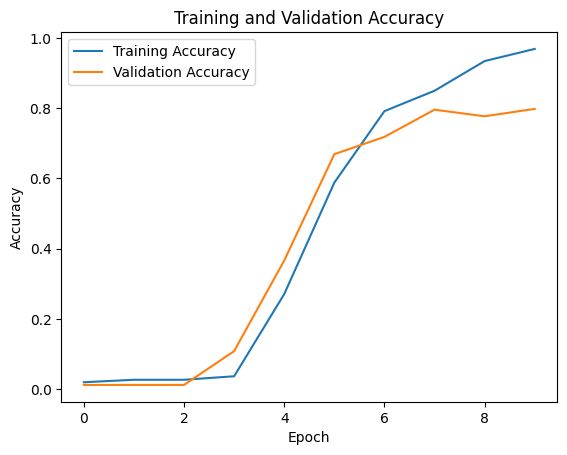

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


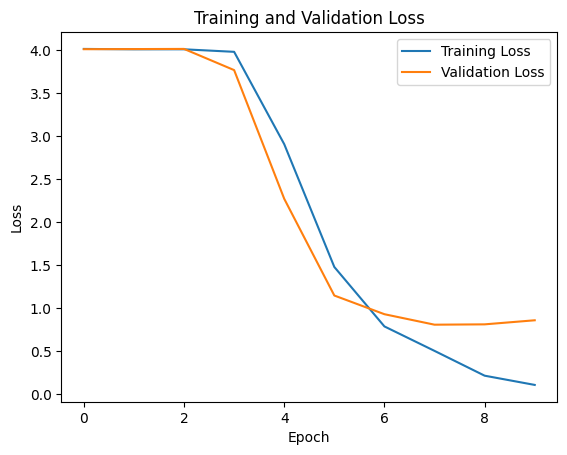

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Get predictions on test data
predictions = model.predict(test_data)

# Initialize counters for false positives
false_positives = 0

# Iterate through each prediction and compare with actual labels
for i in range(len(predictions)):
    # If the prediction is positive (1) but the actual label is negative (0), it's a false positive
    if predictions[i][0] > 0.5 and test_labels[i] == 0:
        false_positives += 1

print("Number of False Positives:", false_positives)


17/17 [==============================] - 4s 234ms/step
Number of False Positives: 4
